Text Mining and Analysis of Financial Annual Reports
====================================================

In [37]:
import fitz #pymupdf extraction tool
import re
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoLocator, MultipleLocator, MaxNLocator

import nltk
from nltk.corpus import stopwords
import math

**NLTK requires a one-time download of stopwords**

In [38]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/george/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Definitions


This is not an exhaustive list and is wholly defined by frequently appearing terms I have found in financial documents. 

In [39]:
search_terms = {
"Liquidity": ["funding", "flows", "cash", "liquid reserves", "repo", "haircut", "cashflows", "drawdowns", "outflows", "inflows", "runoff", "crunch", "drain", "buffer", "collateral"],
"Capital": ["buffers", "capital ratios","capital reserves", "capital requirements", "cushion", "CET1", "Tier 1", "Tier 2", "Tier 3", "capital adequacy", "capital adequacy ratio", "CAR", "capital ratio", "capital position", "capital base", "capital structure", "capital management", "capital planning", "capital allocation", "capital optimization", "capital efficiency", "capital generation", "capital deployment", "capital return", "capital distribution"],
"Credit": ["loans", "lending", "asset quality", "obligor", "counterparty", "exposures", "net exposure","NPL", "nonperforming", "impairment", "cedants", "default", "credit risk", "credit losses", "credit provisions", "credit reserves", "credit requirements"],
"Foreign Exchange": ["forex", "fx", "currency", "exchange rates","currency pairs", "currency risk", "currency exposure", "currency fluctuations", "currency volatility", "currency hedging", "currency swaps", "currency forwards", "currency options", "currency derivatives", "currency contracts", "currency markets", "currency trading", "currency speculation", "currency manipulation", "currency intervention", "currency peg", "currency basket", "currency band", "currency board", "currency union", "currency crisis", "currency war", "currency controls", "currency devaluation", "currency appreciation", "currency depreciation", "currency revaluation", "currency reserve", "currency swap", "currency peg", "currency basket", "currency band", "currency board", "currency union", "currency crisis", "currency war", "currency controls", "currency devaluation", "currency appreciation", "currency depreciation", "currency revaluation", "currency reserve", "currency swap"],
"Regulatory Risk": ["rules", "regulation", "standard", "compliance", "litigation", "enforcement", "supervision", "regulatory", "regulators",],
"Insurance": ["insurance", "underwriting", "premium", "claims", "lapse", "morbidity", "mortality", "longevity", "catastrophe"],
"Operational Risk": ["operational", "resilience", "cyber", "information", "security", "outsourcing", "third party", "reliance", "continuity", "pandemic", "disaster", "people", "processes", "systems", "data", "technology", "infrastructure", "IT", "fraud", "theft", "error", "disruption", "failure", "malicious", "attack","AI"],
"ESG": ["ESG", "environmental", "social", "governance", "sustainability", "green", "climate", "carbon", "emissions", "pollution", "waste", "biodiversity", "conservation", "renewable", "energy", "solar", "wind", "water", "sustainable", "greenhouse", "emissions", "carbon", "footprint", "greenwashing"],
}

# Text extraction

**Data source: JPM Annual Report 2022**

In [40]:
def extractPDF(doc):
    """
    Opens the PDF document, tokenizes text and cleans using regex.
    """
    doc = fitz.open(doc)
    text = ""
    for page in doc:
        text = text + page.get_text()    
    
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

## Data Cleaning

In [41]:
def searchPDF(text):
    """
    Searches the text for each term in the search_terms dictionary.
    """
    results = []
    # Search the text for each term
    for category, words in search_terms.items():
        for word in words:
            presence = word in text
            frequency = text.count(word)
            results.append([word,category,presence,frequency])

    # Create a DataFrame from the results
    df = pd.DataFrame(results, columns=["SearchTerm","Category","Presence", "Frequency"])
    return df

jpm_df = searchPDF(extractPDF('src/jpm/NYSE_JPM_2022.pdf'))
print(jpm_df)


          SearchTerm   Category  Presence  Frequency
0            funding  Liquidity      True        104
1              flows  Liquidity      True         97
2               cash  Liquidity      True        287
3    liquid reserves  Liquidity     False          0
4               repo  Liquidity      True        305
..               ...        ...       ...        ...
168       greenhouse        ESG     False          0
169        emissions        ESG      True          3
170           carbon        ESG      True          8
171        footprint        ESG      True          2
172     greenwashing        ESG     False          0

[173 rows x 4 columns]


# Visualisation

## Setting global rcParams

In [42]:
plt.rcParams['figure.facecolor'] = '#12273F' 
plt.rcParams['axes.facecolor'] = '#12273F'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.edgecolor']='#FFFFFF'
plt.rcParams['axes.labelcolor']='#FFFFFF'
plt.rcParams['text.color']='#FFFFFF'
plt.rcParams['xtick.color']='#FFFFFF'
plt.rcParams['ytick.color']='#FFFFFF'

## Finding frequent terms, ordered by respective category 

In [43]:
category_count = jpm_df.groupby(['Category'])['Frequency'].sum().to_dict()
for category, frequency in category_count.items():
    print(category, frequency)

Capital 168
Credit 1929
ESG 262
Foreign Exchange 91
Insurance 95
Liquidity 1115
Operational Risk 1041
Regulatory Risk 500


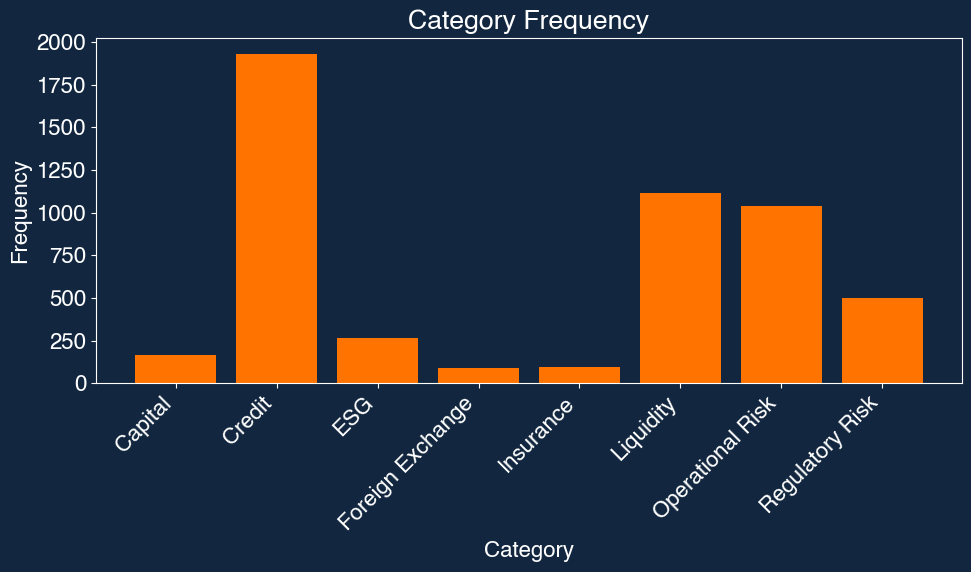

In [44]:
def plot_category_frequency(df):
    """
    Plots the frequency of each category.
    """
    category_count = df.groupby(['Category'])['Frequency'].sum().to_dict()
    #for category, frequency in category_count.items():
        #print(category, frequency)

    fig, ax = plt.subplots(figsize=(10, 6))
    plt.bar(x=list(category_count.keys()), height=list(category_count.values()), color='#FF7300')
    plt.title('Category Frequency')
    plt.xlabel('Category')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.gca().yaxis.set_major_locator(MultipleLocator(250))
    plt.tight_layout()
    plt.show()

plot_category_frequency(jpm_df)


## Individual words

In [62]:
def plot_category(n, category, df, ax=None):
    # Filter category and remove zero frequencies
    category_df = df[df['Category'] == category]
    category_df = category_df[category_df['Frequency'] > 0]
    category_df = category_df.sort_values(by='Frequency', ascending=False)
    
    # Get actual number of terms to plot
    available_terms = len(category_df)
    n_terms = min(n, available_terms)
    
    # Select top n_terms
    top_words = category_df.iloc[:n_terms]['SearchTerm']
    top_frequencies = category_df.iloc[:n_terms]['Frequency']

    if ax is None:
        ax = plt.gca()
        
    ax.set_facecolor('#12273F')
    ax.bar(top_words, top_frequencies, color='#FF7300')
    ax.set_title(category, color='white')
    ax.set_xlabel('Term', color='white')
    ax.set_ylabel('Frequency', color='white')
    ax.tick_params(axis='x', rotation=45, colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.yaxis.set_major_locator(AutoLocator())
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    
    return ax

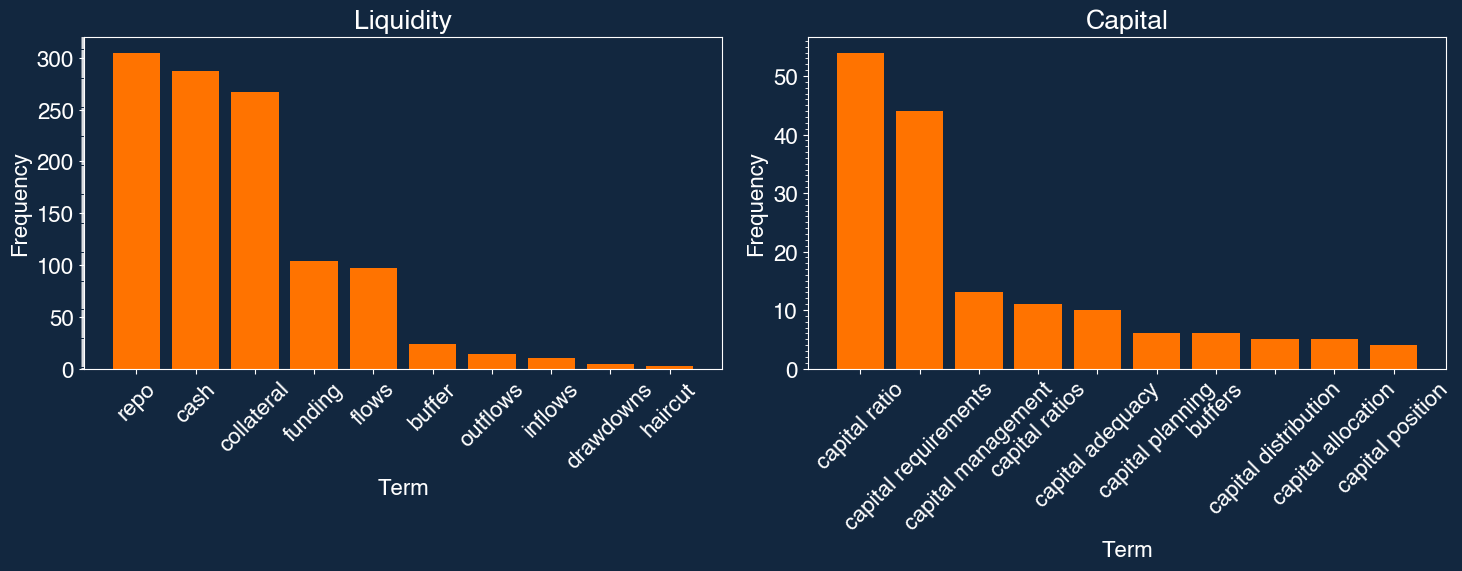

In [63]:
#liquidity, capital plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
plot_category(10, 'Liquidity', jpm_df, ax1)
plot_category(10, 'Capital', jpm_df, ax2)

plt.tight_layout()
plt.show()

Whilst the liquidity graph fails to tell us much, the capital graph suggests heavy usage of capital ratios/requirements. \
This does not tell us much, however n-gram analysis may assist in understanding the context behind these occurrences.

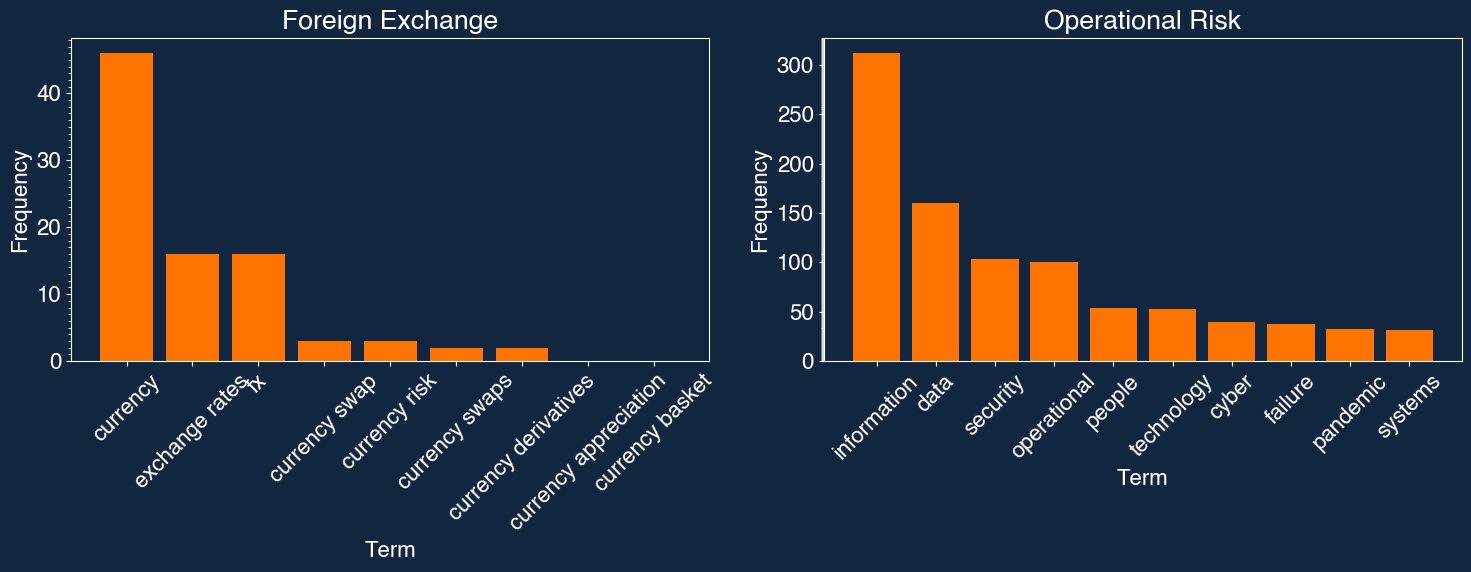

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
plot_category(10, 'Foreign Exchange', jpm_df, ax1)
plot_category(10, 'Operational Risk', jpm_df, ax2)

plt.tight_layout()
plt.show()

ESG analysis may be more helpful due to less generic words, with occurrences of 'climate' and 'energy' suggesting investment preferences. 

# HSBC 2022 Annual Report Analysis

Using a different annual report that is formatted and written differently acts as a helpful sanity check.

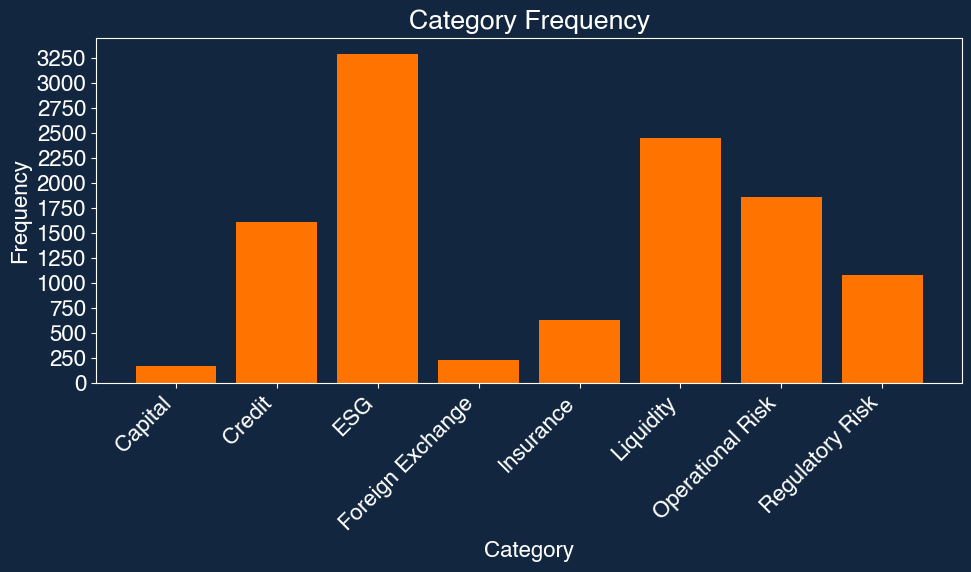

In [27]:
text_hsbc = extractPDF('src/hsbc/230221-annual-report-and-accounts-2022.pdf')
df_hsbc = searchPDF(text_hsbc)
plot_category_frequency(df_hsbc)

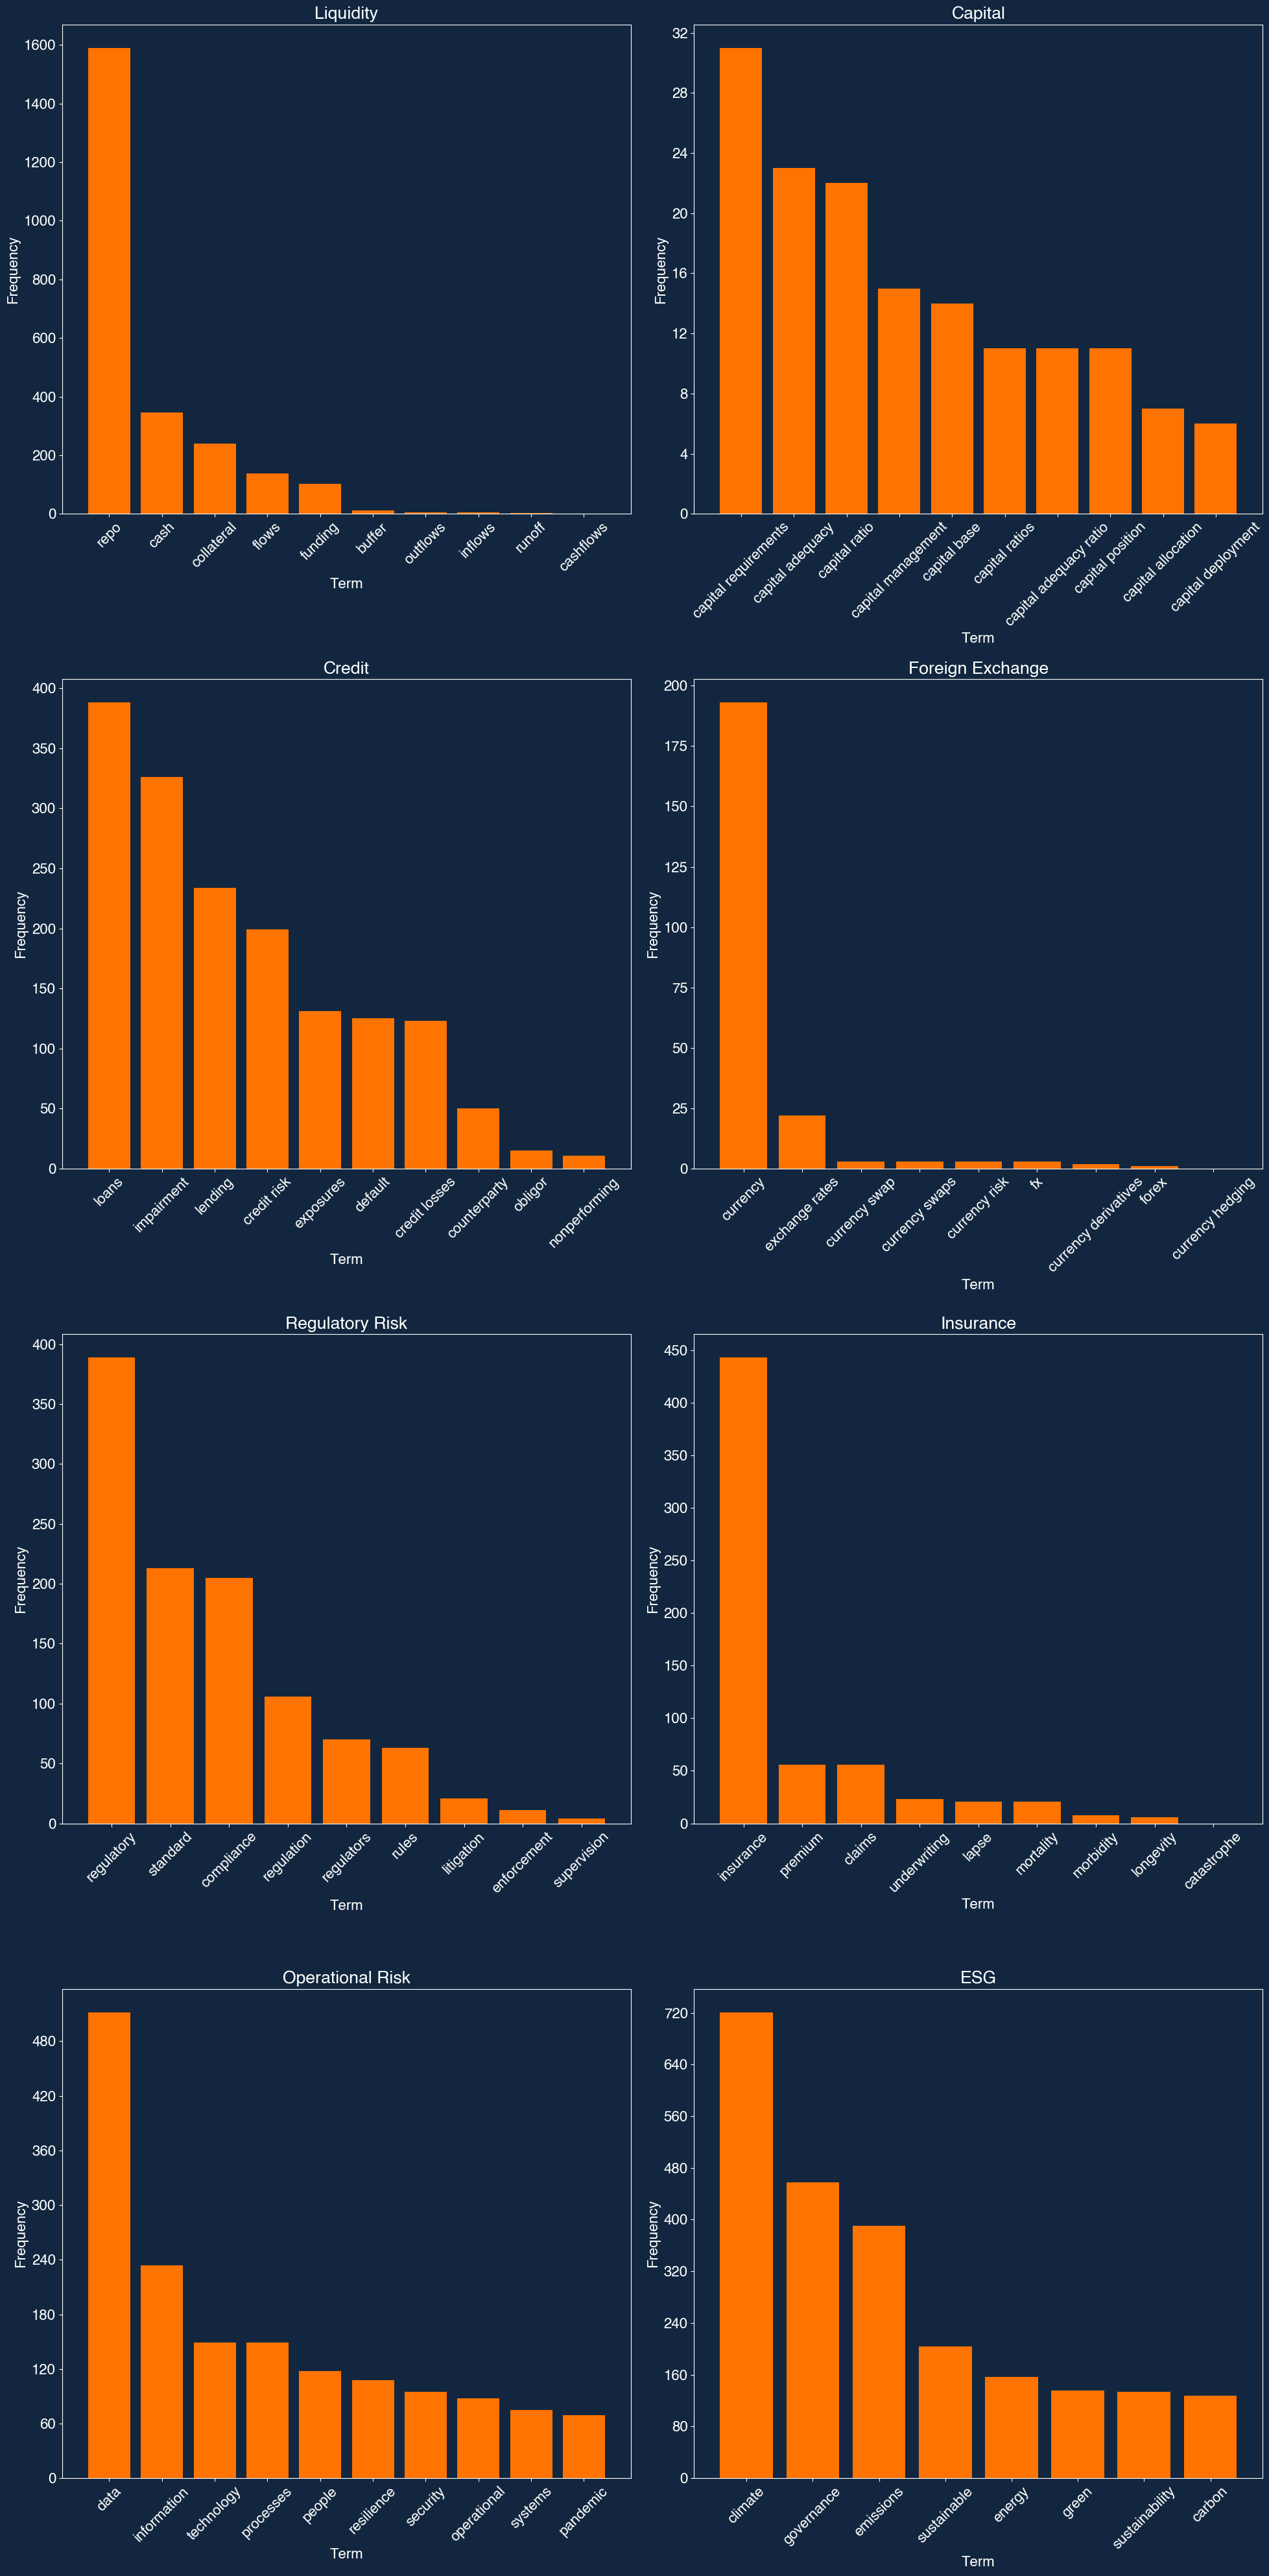

In [28]:
categories = df_hsbc['Category'].unique()
n = len(categories)
cols = 2
rows = math.ceil(n / cols)
fig, axs = plt.subplots(rows, cols, figsize=(20, 10*rows))

axs = axs.flatten()

for i, category in enumerate(categories):
    category_df = df_hsbc[df_hsbc['Category'] == category]
    # sort:dsc
    category_df = category_df.sort_values(by='Frequency', ascending=False)
    #10 most frequent terms
    top_words = category_df.iloc[:10]['SearchTerm']
    top_frequencies = category_df.iloc[:10]['Frequency']
    axs[i].bar(top_words, top_frequencies, color='#FF7300')
    axs[i].set_title(category)
    axs[i].set_xlabel('Term')
    axs[i].set_ylabel('Frequency')
    axs[i].tick_params(axis='x', labelrotation=45)
    axs[i].tick_params(axis='y')
    axs[i].yaxis.set_major_locator(MaxNLocator(nbins=10)) #prevents autolocator from creating >1000 ticks

# remove unused subplots
if n % cols != 0:
    for i in range(n, rows*cols):
        fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

# Comparison between the two

The token count is far greater in the HSBC AR than JPM - making cross-comparisons relatively ineffective.\
However, a comparison matrix acts as an interesting proof of concept.

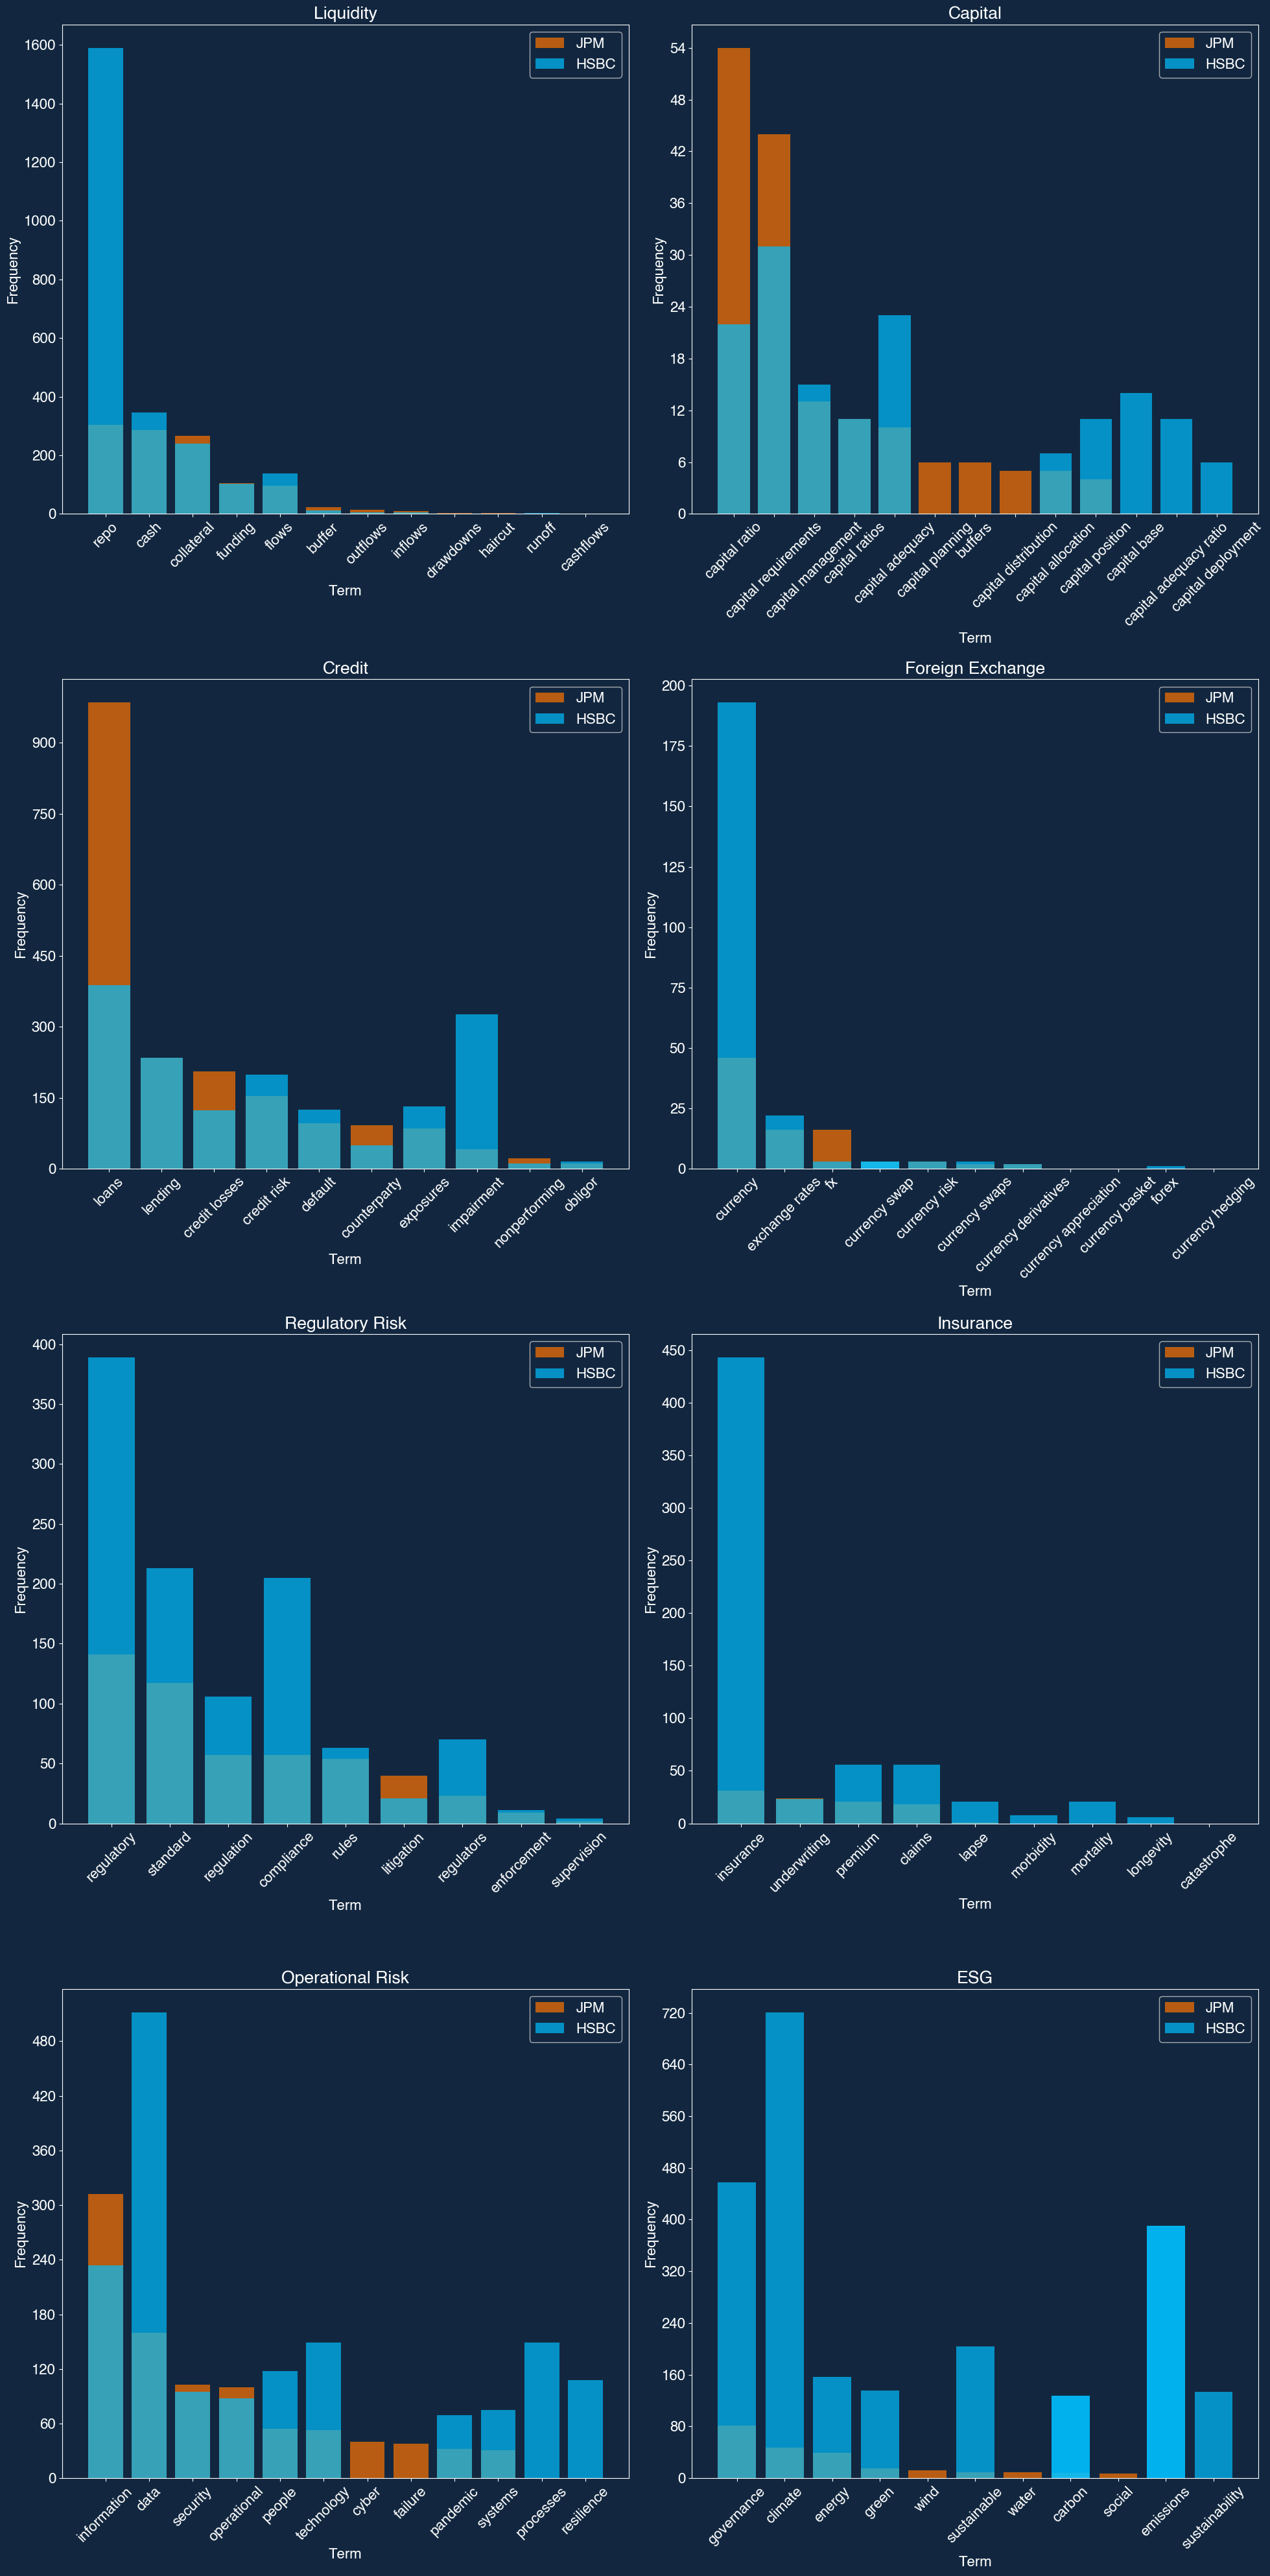

In [29]:
categories = jpm_df['Category'].unique()
n = len(categories)
cols = 2
rows = math.ceil(n / cols)
fig, axs = plt.subplots(rows, cols, figsize=(20, 10*rows))

axs = axs.flatten()

for i, category in enumerate(categories):
    category_jpm_df = jpm_df[jpm_df['Category'] == category]
    category_df_hsbc = df_hsbc[df_hsbc['Category'] == category]
    # sort:dsc
    category_jpm_df = category_jpm_df.sort_values(by='Frequency', ascending=False)
    category_df_hsbc = category_df_hsbc.sort_values(by='Frequency', ascending=False)
    #10 most frequent terms
    top_words_jpm = category_jpm_df.iloc[:10]['SearchTerm']
    top_frequencies_jpm = category_jpm_df.iloc[:10]['Frequency']
    top_words_hsbc = category_df_hsbc.iloc[:10]['SearchTerm']
    top_frequencies_hsbc = category_df_hsbc.iloc[:10]['Frequency']
    axs[i].bar(top_words_jpm, top_frequencies_jpm, color='#FF7300', alpha=0.7, label='JPM')
    axs[i].bar(top_words_hsbc, top_frequencies_hsbc, color='#00BFFF', alpha=0.7, label='HSBC')
    axs[i].set_title(category)
    axs[i].set_xlabel('Term')
    axs[i].set_ylabel('Frequency')
    axs[i].tick_params(axis='x', labelrotation=45)
    axs[i].tick_params(axis='y')
    axs[i].yaxis.set_major_locator(MaxNLocator(nbins=10)) #prevents autolocator from creating >1000 ticks
    axs[i].legend()

# remove unused subplots
if n % cols != 0:
    for i in range(n, rows*cols):
        fig.delaxes(axs[i])

plt.tight_layout()
plt.show()